Disclaimer: 
The analysis results do not represent real outcomes. Sales data is randomly generated and must be used for educational purposes only. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv("Sales_data_modified.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'Филиал', 'Отдел ', 'Подгруппа', 'Товар', 'Sales',
       'Quantity', 'Receipt'],
      dtype='object')

In [8]:
#data cleaning
df['Чек'] = df['Receipt'].astype('str')
df = df[df.Товар != "по чеку"] #delete rows with по чеку
df = df[df.Товар != "излишки кассира"]
df = df[df.Товар != "ПАКЕТ ПЛАТНЫЙ"]
df = df[df.Receipt != "по кассиру"]
df = df[df.Подгруппа != "S010203 КУПОНЫ"]
index_names = df[ df['Sales'] <=0 ].index 
df.drop(index_names, inplace = True) 

/Users/tempibones/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [7]:
customer_df = df.groupby('Чек').agg({'Sales': sum,'Quantity':sum})
customer_df

,Sales,Quantity
Чек,,
536704873.0,76300,56
536705703.0,16306,14
536706095.0,34896,46
536706151.0,36508,36
536707069.0,176480,290
...,...,...
539475616.0,34582,36
539477329.0,32264,34
539478068.0,32916,28


In [10]:
customer_df['AvgOrderValue'] = customer_df['Sales']/customer_df['Quantity']

In [11]:
#Normalizing the data 
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df

,Sales,Quantity,AvgOrderValue
Чек,,,
536704873.0,0.042558,-0.407155,1.649996
536705703.0,-1.519157,-1.719453,0.930452
536706095.0,-0.884393,-0.536734,-1.488215
536706151.0,-0.791656,-0.852634,-0.896571
536707069.0,1.219772,1.566161,-1.616962
...,...,...,...
539475616.0,-0.905142,-0.831461,-1.110020
539477329.0,-1.091464,-0.853057,-1.136278
539478068.0,-1.009737,-1.002114,1.092656


In [13]:
#Cleaning the data 
normalized_df.replace([np.inf, -np.inf], np.nan)
rank_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Sales", "Quantity"], how="all")
normalized_df['AvgOrderValue'].replace('', np.nan, inplace=True)
normalized_df.dropna(subset=['AvgOrderValue'], inplace=True)
normalized_df

,Sales,Quantity,AvgOrderValue
Чек,,,
536704873.0,0.042558,-0.407155,1.649996
536705703.0,-1.519157,-1.719453,0.930452
536706095.0,-0.884393,-0.536734,-1.488215
536706151.0,-0.791656,-0.852634,-0.896571
536707069.0,1.219772,1.566161,-1.616962
...,...,...,...
539475616.0,-0.905142,-0.831461,-1.110020
539477329.0,-1.091464,-0.853057,-1.136278
539478068.0,-1.009737,-1.002114,1.092656


In [14]:
# Silhouette score to determine the number of clusters 
from sklearn.metrics import silhouette_score

for n_cluster in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[["Sales", "Quantity", 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        normalized_df[["Sales", "Quantity", 'AvgOrderValue']], 
        kmeans.labels_)

    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 2 Clusters: 0.4430
Silhouette Score for 3 Clusters: 0.4098
Silhouette Score for 4 Clusters: 0.4081
Silhouette Score for 5 Clusters: 0.3776
Silhouette Score for 6 Clusters: 0.3854
Silhouette Score for 7 Clusters: 0.3826
Silhouette Score for 8 Clusters: 0.3654


In [16]:
#Normalizing the data 
kmeans = KMeans(n_clusters=2).fit(normalized_df[["Sales", "Quantity", 'AvgOrderValue']])

three_cluster_df = normalized_df[["Sales", "Quantity", 'AvgOrderValue']].copy(deep=True)
three_cluster_df['Cluster'] = kmeans.labels_

three_cluster_df

,Sales,Quantity,AvgOrderValue,Cluster
Чек,,,,
536704873.0,0.042558,-0.407155,1.649996,1
536705703.0,-1.519157,-1.719453,0.930452,1
536706095.0,-0.884393,-0.536734,-1.488215,1
536706151.0,-0.791656,-0.852634,-0.896571,1
536707069.0,1.219772,1.566161,-1.616962,0
...,...,...,...,...
539475616.0,-0.905142,-0.831461,-1.110020,1
539477329.0,-1.091464,-0.853057,-1.136278,1
539478068.0,-1.009737,-1.002114,1.092656,1


In [17]:
#Calculating centroids 
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]

data = [cluster1_metrics, cluster2_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = three_cluster_df.columns[0:3]
cluster_center_df

,Sales,Quantity,AvgOrderValue
0,0.796539,0.831352,-0.379177
1,-0.851528,-0.888764,0.405562


In [18]:
three_cluster_df.dtypes

Sales            float64
Quantity         float64
AvgOrderValue    float64
Cluster            int32
dtype: object

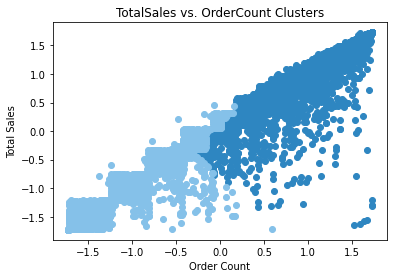

In [19]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['Quantity'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['Sales'],
    c='#2E86C1'
) 

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['Quantity'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['Sales'],
    c='#85C1E9'
) 

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.savefig("TotalSales vs OrderCount")

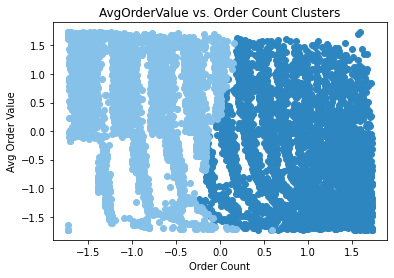

In [20]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['Quantity'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='#2E86C1'
) 

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['Quantity'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='#85C1E9'
) 

plt.title('AvgOrderValue vs. Order Count Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.savefig("AvgOrderValue vs OrderCount.png")

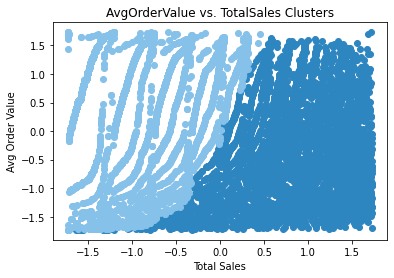

In [21]:
plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['Sales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='#2E86C1'
) 

plt.scatter(
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['Sales'], 
    three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='#85C1E9'
)


plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.savefig("AvgOrderValue vs. TotalSales.png")

In [22]:
cluster0= three_cluster_df.loc[three_cluster_df['Cluster'] == 0]

In [23]:
#The table describes average values for Sales, Quantity sold, and Average Order Value for segment0
customer_df.loc[cluster0.index].describe()

,Sales,Quantity,AvgOrderValue
count,4.220000e+03,4220.000000,4220.000000
mean,1.722307e+05,201.454028,1015.024966
std,9.340325e+05,2669.365117,183.044723
min,1.593800e+04,58.000000,4.527231
25%,9.699600e+04,92.000000,950.663710
50%,1.288260e+05,126.000000,1078.990196
75%,1.873000e+05,186.000000,1133.650219
max,6.047100e+07,173316.000000,1969.200000


In [32]:
#The table describes top categories by quantity sold for segment0
pd.DataFrame(
    df.loc[
        df['Receipt'].isin(cluster0.index)
    ].groupby('Подгруппа').sum()[
        'Quantity'
    ].sort_values(ascending=False).head(2)
)

,Quantity
Подгруппа,
F1505 ОВОЩИ СВЕЖИЕ,74794
"F0208 ПРИПРАВЫ, СПЕЦИИ",33556


In [26]:
#The table describes average values for Sales, Quantity sold, and Average Order Value for segment1 
cluster1 = three_cluster_df.loc[three_cluster_df['Cluster'] == 1]
customer_df.loc[cluster1.index].describe()

,Sales,Quantity,AvgOrderValue
count,3959.000000,3959.000000,3959.000000
mean,39740.110634,35.708007,1126.274086
std,19910.842479,17.430425,182.254810
min,5434.000000,-12.000000,-1233.750000
25%,19426.000000,18.000000,1095.719697
50%,34896.000000,32.000000,1147.000000
75%,51072.000000,48.000000,1190.261905
max,98496.000000,104.000000,2313.875000


In [31]:
#The table describes top categories by quantity sold for segment 1
pd.DataFrame(
    df.loc[
        df['Receipt'].isin(cluster1.index)
    ].groupby('Отдел ').sum()[
        'Quantity'
    ].sort_values(ascending=False).head(2)
)

,Quantity
Отдел,
F02 БАКАЛЕЯ,18236
F09 БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,17524
